<a href="https://colab.research.google.com/github/jobellet/vlPFC_Visual_Geometry/blob/main/LSF_information_and_object_identification_gain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------------------------------------------------------------------
# LSF information and object identification gain
-----------------------------------------------------------------------------
- Analysis of the position and category information contained in the early vlPFC response and the LSF component of images.

- Testing the hypothesis that this early information can serve as prior for better object identification
-----------------------------------------------------------------------------
## Private key
For the notebook to download the data from the Figshare repository prior to acceptance of the manuscript you need to insert the private link token mentioned in the "Code availability" section of the manuscript.

In [ ]:
private_link = input('Enter the private link token:')

# First, download data and import toolboxes

In [ ]:
import os, re, pickle, warnings, time
from pathlib import Path
from itertools import combinations
import sys
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
from pathlib import PurePath
from scipy.stats import gaussian_kde
import jax.numpy as jnp
from jax import jit
# Determine the path to the repository based on the environment
IN_COLAB = False
IN_KAGGLE = False # Assuming not in Kaggle for now
try:
    if 'google.colab' in str(get_ipython()):
        IN_COLAB = True
except NameError:
    pass

if IN_COLAB:
    path_to_repo = '/content/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
elif IN_KAGGLE:
    path_to_repo = '/kaggle/working/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex'
else:
    # Assume local environment where the .py file is in the root of the repo
    path_to_repo = '.'

# Only clone if not already present
if not os.path.exists(path_to_repo):
    os.system("git clone https://github.com/jobellet/Dynamics-of-Visual-Representations-in-a-Macaque-Ventrolateral-Prefrontal-Cortex.git " + path_to_repo)

sys.path.append(path_to_repo)
sys.path.append(os.path.join(path_to_repo, 'utils'))

from extract_and_download_data import download_files, unzip
from image_processing import m_pathway_filter_gaussian

FIG_DIR = Path("Figures") # Convert to Path object
os.makedirs(FIG_DIR, exist_ok=True)
CACHE_DIR = Path(".cache");   CACHE_DIR.mkdir(exist_ok=True) # From Category decoding

# Define the directory where files are downloaded
DOWNLOAD_DIR = Path("downloads") # Convert to Path object
os.makedirs(DOWNLOAD_DIR, exist_ok=True)


# -------------------------------------------------------------------
# Download required data files once (using the new method)
files_to_download = [
    "Spike_count_even_sessions.npy",
    "Spike_count_odd_sessions.npy",
    "hvm_public_extended_meta.csv",
    "deepNetFeatures.zip",
    "background_variations_images.zip",
    "high_variation_stimuli.zip",
]
# Pass the correct path to file_code_mapping.csv to download_files
download_success = download_files(path_to_repo, files_to_download, private_link=private_link)

meta_downloaded_path = DOWNLOAD_DIR / "hvm_public_extended_meta.csv" # Use Path object
dnn_zip_downloaded_path = DOWNLOAD_DIR / "deepNetFeatures.zip" # Use Path object
even_downloaded_path = DOWNLOAD_DIR / "Spike_count_even_sessions.npy" # Use Path object
odd_downloaded_path = DOWNLOAD_DIR / "Spike_count_odd_sessions.npy" # Use Path object


meta_downloaded = meta_downloaded_path.exists()
dnn_zip_downloaded = dnn_zip_downloaded_path.exists()
even_downloaded_check = even_downloaded_path.exists()
odd_downloaded_check = odd_downloaded_path.exists()


if not (meta_downloaded and dnn_zip_downloaded):
    print("Failed to download necessary files. Exiting.")
    # exit() # Do not exit, just skip the parts that require these files

if dnn_zip_downloaded:
    # Update unzip to use the downloaded zip path and specify the extraction directory
    unzip(dnn_zip_downloaded_path, "deepNetFeatures")

Successfully downloaded downloads/hvm_public_extended_meta.csv.
Successfully downloaded downloads/background_variations_images.zip.
Successfully downloaded downloads/high_variation_stimuli.zip.
Successfully downloaded downloads/deepNetFeatures.zip.
Successfully downloaded downloads/Spike_count_even_sessions.npy.
Successfully downloaded downloads/Spike_count_odd_sessions.npy.


# Category-abstract position decoding

## Analysis

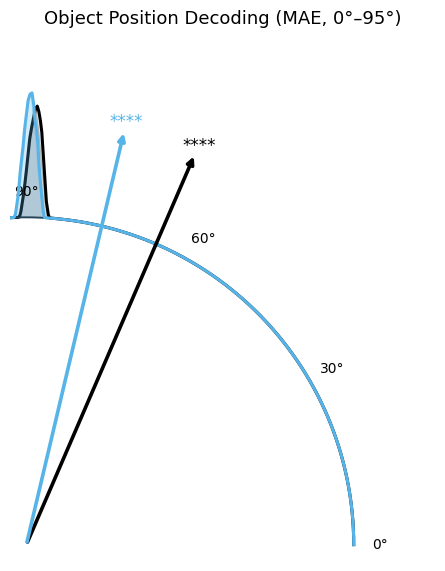

Figure saved → Figures/objpos_decoding_quartercircle_deg.png
                 Figures/objpos_decoding_quartercircle_deg.svg
                 Figures/objpos_decoding_quartercircle_deg.pdf


In [ ]:
def load_and_align(pkl_path, meta_df):
    with open(pkl_path, "rb") as fh:
        d = pickle.load(fh)
    X = d["penultimate"]
    if X.ndim > 2:
        X = X.reshape(X.shape[0], -1)
    names = [Path(n).stem for n in d["image_names"]]
    idx = [names.index(b) for b in meta_df["base"]]
    return X[idx].astype(np.float64)

def predict_angles(net, pkl_path, meta_df, y_target, categories):
    X = load_and_align(pkl_path, meta_df)
    pred_t = np.zeros_like(y_target, dtype=np.float64)
    for cat in categories:
        tr = meta_df["category_name"] != cat
        te = ~tr
        pca = PCA(n_components=50, random_state=42)
        Xtr = pca.fit_transform(X[tr])
        Xte = pca.transform(X[te])
        reg = LinearRegression().fit(Xtr, y_target[tr])
        pred_t[te] = reg.predict(Xte)
    return np.arctan2(pred_t[:, 1], pred_t[:, 0])

def circ_diff(a, b):
    return np.arctan2(np.sin(a - b), np.cos(a - b))

def perm_pvalue(empirical, null_samples):
    if null_samples is None or len(null_samples) == 0 or np.isnan(empirical):
        return np.nan
    return (np.sum(null_samples <= empirical) + 1) / (len(null_samples) + 1)

def p_to_stars(p):
    if np.isnan(p):  return ''
    if p < 1e-4:     return '****'
    if p < 1e-3:     return '***'
    if p < 1e-2:     return '**'
    if p < 5e-2:     return '*'
    return ''

# ───────────────────────── Quarter‑circle drawing ─────────────────────────
THETA_MAX_DEG = 95   # extend slightly beyond 90° to include left KDE tail
THETA_MAX     = np.deg2rad(THETA_MAX_DEG)

def _deg_label(ax, R, deg):
    th = np.deg2rad(deg)
    ax.text(R*1.08*np.cos(th), R*1.08*np.sin(th), f'{deg}°',
            ha='center', va='center', fontsize=10, zorder=5)

def quartercircle_axes(ax, R=1.0, theta_max=THETA_MAX):
    """Draw only a quarter of a circle (0° → ~95°) with degree labels."""
    t = np.linspace(0, theta_max, 300)
    ax.plot(R*np.cos(t), R*np.sin(t), lw=1.2, color='black', zorder=2)

    # Degree labels around the arc
    for deg in (0, 30, 60, 90):
        _deg_label(ax, R, deg)

    # Neat framing for the first quadrant
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-R*0.05, R*1.25)
    ax.set_ylim(-R*0.05, R*1.55)
    ax.axis('off')

def draw_kde_bump(ax, samples, *,
                  R=1.0, height=0.35, n=400, color="black",
                  alpha_fill=0.22, lw=2.0, z=3, theta_max=THETA_MAX):
    """
    Draw a KDE "bump" outside the quarter arc.
    Samples are cropped to 1–99 percentiles to avoid extreme tails.
    Evaluated only on [0, theta_max] (default 95°).
    """
    samples = np.asarray(samples).ravel()
    if samples.size < 2 or not np.all(np.isfinite(samples)):
        return

    lo, hi = np.percentile(samples, [1, 99])
    samples = samples[(samples >= lo) & (samples <= hi)]
    if samples.size < 2:
        return

    try:
        kde = gaussian_kde(samples)
    except np.linalg.LinAlgError:
        if np.allclose(samples, samples[0]):
            theta = float(samples[0])
            theta = np.clip(theta, 0.0, theta_max)
            xb, yb = R*np.cos(theta), R*np.sin(theta)
            xd, yd = (R+height)*np.cos(theta), (R+height)*np.sin(theta)
            ax.plot([xb, xd], [yb, yd], color=color, lw=lw, zorder=z)
        return

    thetas = np.linspace(0.0, theta_max, n)  # evaluate only over the quarter
    dens = kde(thetas)
    if dens.max() == 0:
        return
    dens /= np.max(dens)

    f = height * dens
    xb, yb = R*np.cos(thetas),     R*np.sin(thetas)
    xd, yd = (R+f)*np.cos(thetas), (R+f)*np.sin(thetas)

    ax.fill_between(xb, yb, yd, color=color, alpha=alpha_fill, zorder=z)
    ax.plot(xd, yd, color=color, lw=lw, zorder=z+1)

# ───────────────────────── Config (unchanged) ─────────────────────────
plt.rcParams.update({"svg.fonttype": "none"})  # keep text editable in SVG
NEURAL_COLOR = (0.3372549, 0.70588235, 0.91372549)  # BLUE
DNN_COLOR    = (0.0, 0.0, 0.0)                        # BLACK

FIG_DIR = Path(globals().get("FIG_DIR", "Figures")); FIG_DIR.mkdir(exist_ok=True)
meta_downloaded_path = globals().get("meta_downloaded_path", "downloads/hvm_public_extended_meta.csv")
even_downloaded_path = globals().get("even_downloaded_path", "downloads/Spike_count_even_sessions.npy")
odd_downloaded_path  = globals().get("odd_downloaded_path",  "downloads/Spike_count_odd_sessions.npy")
dnn_zip_downloaded   = globals().get("dnn_zip_downloaded", True)

even_downloaded_check = Path(even_downloaded_path).exists()
odd_downloaded_check  = Path(odd_downloaded_path).exists()

# ───────────────────────── Data prep (unchanged) ─────────────────────────
meta = pd.read_csv(meta_downloaded_path)
meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)

# keep only the 2,560 high-variation stimuli (skip first 640)
valid_idx = np.arange(640, len(meta))
meta = meta.iloc[valid_idx].reset_index(drop=True)

# centroid → polar angle (y, x)
pos = np.vstack((meta["centroid_y"].values, meta["centroid_x"].values)).T
pos = (pos - 128) / 256 * 8
true_angle = np.arctan2(pos[:, 1], pos[:, 0])  # note: (y, x) swap preserved
y_target = np.column_stack((np.cos(true_angle), np.sin(true_angle)))

categories   = meta["category_name"].unique()
cat_labels   = meta["category_name"].values
_cat_to_idx  = {c: np.flatnonzero(cat_labels == c) for c in categories}

# ───────────────────── Neural decoding (Early) (unchanged) ─────────────────────
if even_downloaded_check and odd_downloaded_check:
    rate_even = np.load(even_downloaded_path, allow_pickle=True)
    rate_odd  = np.load(odd_downloaded_path,  allow_pickle=True)
    rate = ((rate_even + rate_odd) / 2.0)[valid_idx]  # align to meta

    time_range_early = slice(5, 9)  # 50–90 ms
    feats = rate[:, :, time_range_early].reshape(rate.shape[0], -1)

    pred_target = np.zeros_like(y_target)
    for cat in categories:
        tr = meta["category_name"] != cat
        te = ~tr
        pca = PCA(n_components=50, random_state=42)
        Xtr = pca.fit_transform(feats[tr])
        Xte = pca.transform(feats[te])
        reg = LinearRegression().fit(Xtr, y_target[tr])
        pred_target[te] = reg.predict(Xte)

    pred_ang = np.arctan2(pred_target[:, 1], pred_target[:, 0])
    angle_diff_early = circ_diff(pred_ang, true_angle)

    N_PERM = 10_000
    mae_neural = {"Early": np.abs(angle_diff_early).mean()}
    mae_perm_neural = {"Early": np.empty(N_PERM, dtype=np.float64)}

    rng = np.random.default_rng(42)
    for i in range(N_PERM):
        shuffled = true_angle.copy()
        for _, idxs in _cat_to_idx.items():
            shuffled[idxs] = rng.permutation(shuffled[idxs])
        diff_p = circ_diff(pred_ang, shuffled)
        mae_perm_neural["Early"][i] = np.abs(diff_p).mean()
else:
    print("Skipping neural decoding (even/odd data not available).")
    N_PERM = 10_000
    mae_neural = {"Early": np.nan}
    mae_perm_neural = {"Early": np.array([], dtype=np.float64)}

# ───────────────────── Low‑pass DNN decoding (pooled) (unchanged) ─────────────────────
if dnn_zip_downloaded:
    feature_dir = Path("deepNetFeatures")
    p = re.compile(r"^(?P<net>.*?)_features_high_variation_lowpass\.pkl$")
    feat_files = [(m.group("net"), f) for f in feature_dir.glob("*.pkl") if (m := p.match(f.name))]

    if len(feat_files) == 0:
        print("No low-pass DNN feature files found.")
        perm_mae_dnn = np.array([]); mae_dnn = np.nan; err_per_trial = np.array([])
    else:
        pred_angles_all = Parallel(n_jobs=-1, backend="loky")(
            delayed(predict_angles)(n, f, meta, y_target, categories)
            for n, f in feat_files
        )
        pred_angles_all = np.vstack(pred_angles_all)  # n_nets × n_trials
        avg_cos = np.cos(pred_angles_all).mean(axis=0)
        avg_sin = np.sin(pred_angles_all).mean(axis=0)
        avg_pred_angle = np.arctan2(avg_sin, avg_cos)

        err_per_trial = np.abs(circ_diff(avg_pred_angle, true_angle))
        np.save("mean_pos_error_per_trial.npy", err_per_trial)

        mae_dnn = err_per_trial.mean()

        perm_mae_dnn = np.empty(N_PERM, dtype=np.float64)
        rng = np.random.default_rng(123)
        for i in range(N_PERM):
            shuffled = true_angle.copy()
            for _, idxs in _cat_to_idx.items():
                shuffled[idxs] = rng.permutation(shuffled[idxs])
            diff_p = circ_diff(avg_pred_angle, shuffled)
            perm_mae_dnn[i] = np.abs(diff_p).mean()
else:
    print("Skipping DNN decoding (zip not available).")
    perm_mae_dnn = np.array([]); mae_dnn = np.nan; err_per_trial = np.array([])

# ───────────────────── Stats (unchanged) ─────────────────────
p_neural = perm_pvalue(mae_neural.get("Early", np.nan), mae_perm_neural.get("Early", np.array([])))
p_dnn    = perm_pvalue(mae_dnn, perm_mae_dnn)

# ───────────────────── Plot (quarter‑circle up to 95°) ─────────────────────
have_neural = (len(mae_perm_neural["Early"]) > 0) and (not np.isnan(mae_neural.get("Early", np.nan)))
have_dnn    = (perm_mae_dnn.size > 0) and (not np.isnan(mae_dnn))

if have_neural or have_dnn:
    fig, ax = plt.subplots(1, 1, figsize=(7.0, 5.6), constrained_layout=True)
    quartercircle_axes(ax, R=1.0, theta_max=THETA_MAX)

    # KDE bumps — DNN: black, NEURAL: blue
    if have_dnn:
        draw_kde_bump(ax, perm_mae_dnn, R=1.0, height=0.34,
                      color="black", alpha_fill=0.18, lw=2.2, z=3, theta_max=THETA_MAX)
    if have_neural:
        draw_kde_bump(ax, mae_perm_neural["Early"], R=1.0, height=0.38,
                      color=NEURAL_COLOR, alpha_fill=0.26, lw=2.2, z=4, theta_max=THETA_MAX)

    # Observed MAE rays — clip angle to 95° so arrows stay inside the panel
    eps = np.deg2rad(0.25)
    if have_dnn:
        thD = np.clip(mae_dnn, 0.0, THETA_MAX - eps)
        ax.annotate("", xy=((1.0 + 0.30) * np.cos(thD), (1.0 + 0.30) * np.sin(thD)),
                    xytext=(0, 0),
                    arrowprops=dict(arrowstyle='-|>', lw=2.6, color=DNN_COLOR),
                    zorder=6)
        s = p_to_stars(p_dnn)
        if s:
            ax.text((1.0 + 0.33) * np.cos(thD), (1.0 + 0.33) * np.sin(thD),
                    s, ha='center', va='center', fontsize=12, color=DNN_COLOR, zorder=7)

    if have_neural:
        thN = np.clip(mae_neural["Early"], 0.0, THETA_MAX - eps)
        ax.annotate("", xy=((1.0 + 0.30) * np.cos(thN), (1.0 + 0.30) * np.sin(thN)),
                    xytext=(0, 0),
                    arrowprops=dict(arrowstyle='-|>', lw=2.6, color=NEURAL_COLOR),
                    zorder=6)
        s = p_to_stars(p_neural)
        if s:
            ax.text((1.0 + 0.33) * np.cos(thN), (1.0 + 0.33) * np.sin(thN),
                    s, ha='center', va='center', fontsize=12, color=NEURAL_COLOR, zorder=7)

    ax.set_title("Object Position Decoding (MAE, 0°–95°)", pad=10, fontsize=13)

    out_png = FIG_DIR / "objpos_decoding_quartercircle_deg.png"
    out_svg = FIG_DIR / "objpos_decoding_quartercircle_deg.svg"
    out_pdf = FIG_DIR / "objpos_decoding_quartercircle_deg.pdf"
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    fig.savefig(out_svg, bbox_inches="tight")
    fig.savefig(out_pdf, bbox_inches="tight")
    plt.show()
    print(f"Figure saved → {out_png}\n                 {out_svg}\n                 {out_pdf}")
else:
    print("Skipping plot: no permutation data available.")

## Illustration of decoding crossvalidation

Saved figure:
  Figures/illustration_position_decoding_blurred.png
  Figures/illustration_position_decoding_blurred.svg


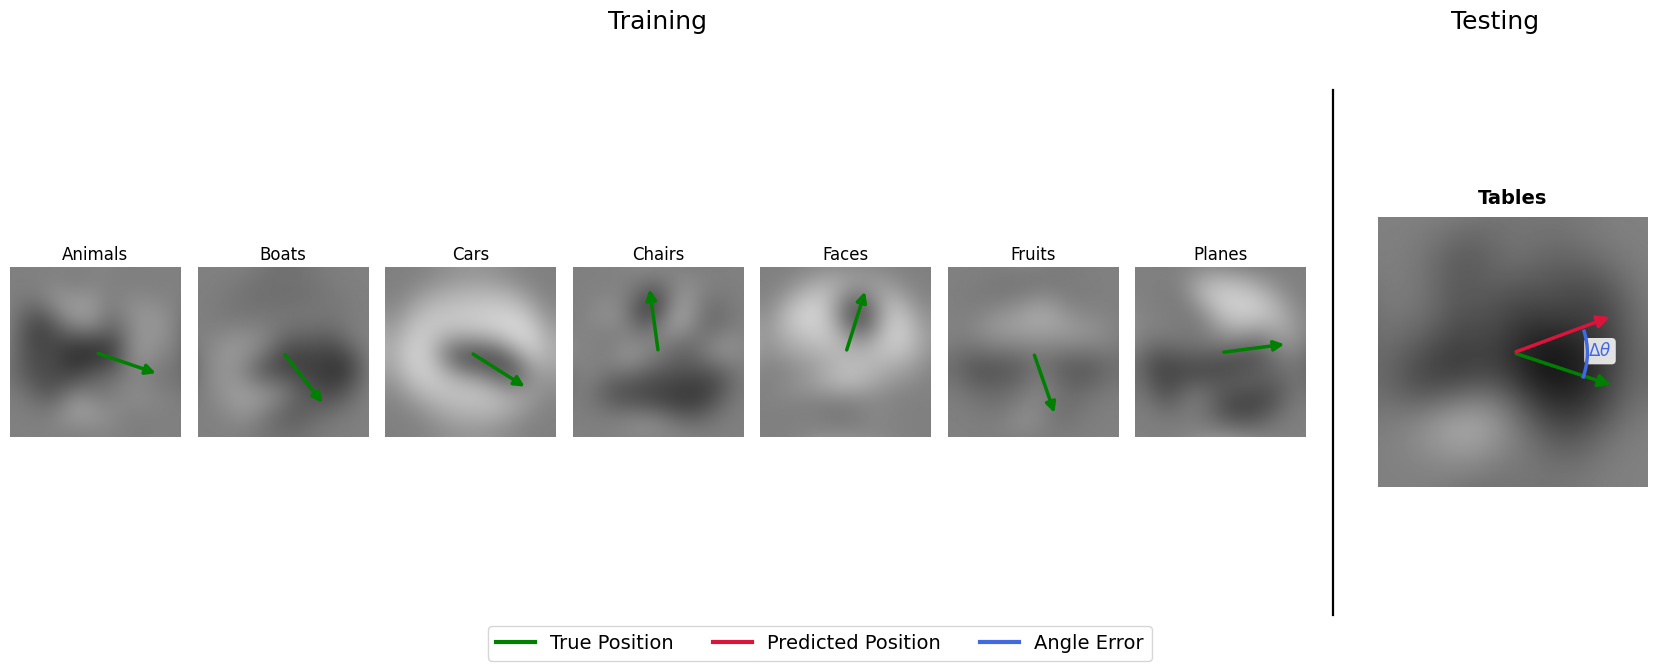

In [ ]:
import io
import zipfile
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Arc
from matplotlib.lines import Line2D
from PIL import Image, ImageOps
from matplotlib import rcParams
from fractions import Fraction

# --- Configuration ---
DOWNLOAD_DIR = Path("downloads")
FIG_DIR = Path("Figures")
META_CSV = DOWNLOAD_DIR / "hvm_public_extended_meta.csv"
ZIP_HIGH = DOWNLOAD_DIR / "high_variation_stimuli.zip"
FOV_DEG = 8.0  # Field-of-view for Gaussian filter

FIG_DIR.mkdir(parents=True, exist_ok=True)
DOWNLOAD_DIR.mkdir(parents=True, exist_ok=True)

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

# --- IO and Image Helpers ---
def open_zip(zip_path: Path) -> zipfile.ZipFile:
    if not zip_path.exists():
        print(f"Warning: ZIP file not found at {zip_path}. Using placeholder images.")
        return None
    return zipfile.ZipFile(zip_path, "r")

def load_meta_high_variation(meta_csv: Path) -> pd.DataFrame:
    if not meta_csv.exists():
        raise FileNotFoundError(f"Missing metadata file: {meta_csv}")
    meta = pd.read_csv(meta_csv)
    meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)
    # NOTE: metadata stores centroid_x / centroid_y; code below uses (row, col)=(y, x)
    return meta.iloc[np.arange(640, len(meta))].reset_index(drop=True)

def load_grayscale_from_zip(zf: zipfile.ZipFile, base_stem: str):
    if zf is None: return None
    resize_dim = (256, 256)
    target = f"{base_stem}.png"
    for name in zf.namelist():
        if name.endswith(target):
            with zf.open(name) as fh:
                im = Image.open(io.BytesIO(fh.read())).convert("L")
                im = im.resize(resize_dim, Image.Resampling.LANCZOS)
                return np.asarray(im)
    return None

def get_representative_blurred_images(df: pd.DataFrame, zf: zipfile.ZipFile, categories: list):
    """Fetches a representative image, blurs it, and gets its centroid (row, col) = (y, x)."""
    data = {}
    for cat in categories:
        row = df[df["category_name"] == cat].iloc[0]
        base = row["base"]
        # Store as (row, col) i.e. (y, x) for image indexing
        centroid_rc = (row["centroid_y"], row["centroid_x"])
        original_img = load_grayscale_from_zip(zf, base)

        if original_img is None:
            blurred_img = np.full((256, 256), 128, dtype=np.uint8)
            centroid_rc = (128, 128)
        else:
            # Assumes you have this function in your workspace
            blurred_img = m_pathway_filter_gaussian(original_img, fov_deg=FOV_DEG)

        data[cat] = {"image": blurred_img, "centroid": centroid_rc}
    return data

# --- Angle utilities ---
def angle_deg_from_center_image_coords(point_rc, center_rc=(128, 128)):
    """
    Angle in degrees from center to point, using standard cartesian convention.
    Image has (row, col) with y down, so invert vertical.
    """
    r, c = point_rc
    cr, cc = center_rc
    dx = c - cc
    dy = cr - r  # invert sign for image coords
    return np.degrees(np.arctan2(dy, dx)) % 360.0

def minor_signed_delta(a_deg, b_deg):
    """Signed smallest difference b - a in degrees, in (-180, 180]."""
    return ((b_deg - a_deg + 180) % 360) - 180

def polar_to_image_xy(angle_deg, radius, center_rc=(128, 128)):
    """Polar (deg, radius) → image coords (x=col, y=row) with y-down."""
    cr, cc = center_rc
    rad = np.radians(angle_deg)
    x = cc + radius * np.cos(rad)
    y = cr - radius * np.sin(rad)
    return x, y



# --- Plotting Helpers ---
def plot_training_image(ax, data, label):
    ax.imshow(data["image"], cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
    centroid = data["centroid"]  # (row, col)
    vec = np.array(centroid) - np.array([128, 128])
    nrm = np.linalg.norm(vec)
    dir_vec = vec / nrm if nrm > 0 else np.array([0, 0])
    end = np.array([128, 128]) + dir_vec * 100

    ax.add_patch(FancyArrowPatch((128, 128), end,
                                 arrowstyle='-|>', mutation_scale=15, lw=2.5, color='green'))
    ax.set_title(label, fontsize=12, pad=5)

def plot_test_image(ax, data, label):
    ax.imshow(data["image"], cmap='gray', vmin=0, vmax=255)
    ax.axis('off')
    for spine in ax.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(2.5)
        spine.set_visible(True)

    center = (128, 128)

    # ---- Arrows (unchanged) ----
    true_rc = data["centroid"]  # (row, col)
    vec_t = np.array(true_rc) - np.array(center)
    n_t = np.linalg.norm(vec_t)
    dir_t = vec_t / n_t if n_t > 0 else np.array([0, 0])
    end_t = np.array(center) + dir_t * 100

    # Simulated predicted centroid (example)
    pred_rc_sim = (true_rc[0] + 20, true_rc[1] - 30)
    vec_p = np.array(pred_rc_sim) - np.array(center)
    n_p = np.linalg.norm(vec_p)
    dir_p = vec_p / n_p if n_p > 0 else np.array([0, 0])
    end_p = np.array(center) + dir_p * 100

    ax.add_patch(FancyArrowPatch(center, end_t, arrowstyle='-|>', mutation_scale=18, lw=2.5, color='green'))
    ax.add_patch(FancyArrowPatch(center, end_p, arrowstyle='-|>', mutation_scale=18, lw=2.5, color='crimson'))


    true_swapped_rc = (true_rc[1], true_rc[0])
    pred_swapped_rc = (pred_rc_sim[1], pred_rc_sim[0])

    theta_true = angle_deg_from_center_image_coords(true_swapped_rc, center)
    theta_pred = angle_deg_from_center_image_coords(pred_swapped_rc, center)
    dtheta = minor_signed_delta(theta_true, theta_pred)
    theta2 = theta_true + dtheta
    theta1_draw, theta2_draw = (theta_true, theta2) if dtheta >= 0 else (theta2, theta_true)

    arc_radius = 70
    arc = Arc((center[1], center[0]),
              width=2*arc_radius, height=2*arc_radius,
              angle=0, theta1=theta1_draw, theta2=theta2_draw,
              lw=2.5, color='royalblue', zorder=5)
    ax.add_patch(arc)

    # Label as a fraction of π
    mid_angle = (theta1_draw + theta2_draw) / 2.0
    tx, ty = polar_to_image_xy(mid_angle, arc_radius + 12, center)
    ax.text(tx, ty, rf"$\Delta\theta$",
            fontsize=12, color='royalblue', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='none', alpha=0.85))

    ax.set_title(label, fontsize=14, pad=10, weight='bold')

# --- Main Script ---
meta_hv = load_meta_high_variation(META_CSV)
zip_file = open_zip(ZIP_HIGH)
categories = sorted(meta_hv["category_name"].unique())

train_cats, test_cat = categories[:7], categories[7]
train_data = get_representative_blurred_images(meta_hv, zip_file, train_cats)
test_data = get_representative_blurred_images(meta_hv, zip_file, [test_cat])
if zip_file: zip_file.close()

fig = plt.figure(figsize=(18, 7))
L, R, B, T = 0.05, 0.98, 0.1, 0.85
xsplit = L + 0.72
fig.add_artist(Line2D([xsplit + 0.015, xsplit + 0.015], [B, T], lw=1.6, color="black", zorder=5))

fig.text((L + xsplit)/2, T + 0.08, "Training", ha="center", va="bottom", fontsize=18)
fig.text((xsplit + R)/2, T + 0.08, "Testing",  ha="center", va="bottom", fontsize=18)

grid_spec_train = fig.add_gridspec(1, 7, left=L, right=xsplit, bottom=B, top=T, wspace=0.1)
for i, cat in enumerate(train_cats):
    ax = fig.add_subplot(grid_spec_train[0, i])
    plot_training_image(ax, train_data[cat], cat)

grid_spec_test = fig.add_gridspec(1, 1, left=xsplit + 0.04, right=R - 0.02, bottom=B, top=T)
ax_test = fig.add_subplot(grid_spec_test[0, 0])
plot_test_image(ax_test, test_data[test_cat], f"{test_cat}")

legend_elements = [
    Line2D([0], [0], color='green',   lw=3, label='True Position'),
    Line2D([0], [0], color='crimson', lw=3, label='Predicted Position'),
    Line2D([0], [0], color='royalblue', lw=3, label='Angle Error')
]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=3, fontsize=14)

out_png = FIG_DIR / "illustration_position_decoding_blurred.png"
out_svg = FIG_DIR / "illustration_position_decoding_blurred.svg"
fig.savefig(out_png, dpi=200, bbox_inches="tight")
fig.savefig(out_svg, bbox_inches="tight")
print(f"Saved figure:\n  {out_png}\n  {out_svg}")

plt.show()

# Object-generalizing category information

## Analysis

Pairwise category decoding — Neural (50–90 ms)…
Pairwise category decoding — Low‑pass DNN …
   · decoding CLIP_RN50_features_high_variation_lowpass.pkl
   · decoding OpenCLIP_ViT-B_32_openai_features_high_variation_lowpass.pkl
   · decoding OpenCLIP_RN101_openai_features_high_variation_lowpass.pkl
   · decoding DeiT_small_distilled_patch16_224_features_high_variation_lowpass.pkl
   · decoding DINO_ResNet50_features_high_variation_lowpass.pkl
   · decoding EfficientNet_B0_features_high_variation_lowpass.pkl
   · decoding ViT_B16_DINO_features_high_variation_lowpass.pkl
   · decoding CLIP_ViT-B_32_features_high_variation_lowpass.pkl
   · decoding MobileNetV3_small_100_features_high_variation_lowpass.pkl
   · decoding Swin_large_patch4_window7_224_features_high_variation_lowpass.pkl
   · decoding ConvNeXt_tiny_in22ft1k_features_high_variation_lowpass.pkl
   · decoding ViT_S16_DINO_features_high_variation_lowpass.pkl
   · decoding Swin_base_patch4_window7_224_features_high_variation_lowpas

/tmp/ipython-input-1790691286.py:256: RuntimeWarning: invalid value encountered in divide
  mean_prob_dnn = np.where(cnt_prob > 0, sum_prob / cnt_prob, np.nan)


Saved:
  Figures/pairwise_combined_upper_neural_lower_dnn.png
  Figures/pairwise_combined_upper_neural_lower_dnn.svg
  Figures/pairwise_combined_upper_neural_lower_dnn.pdf


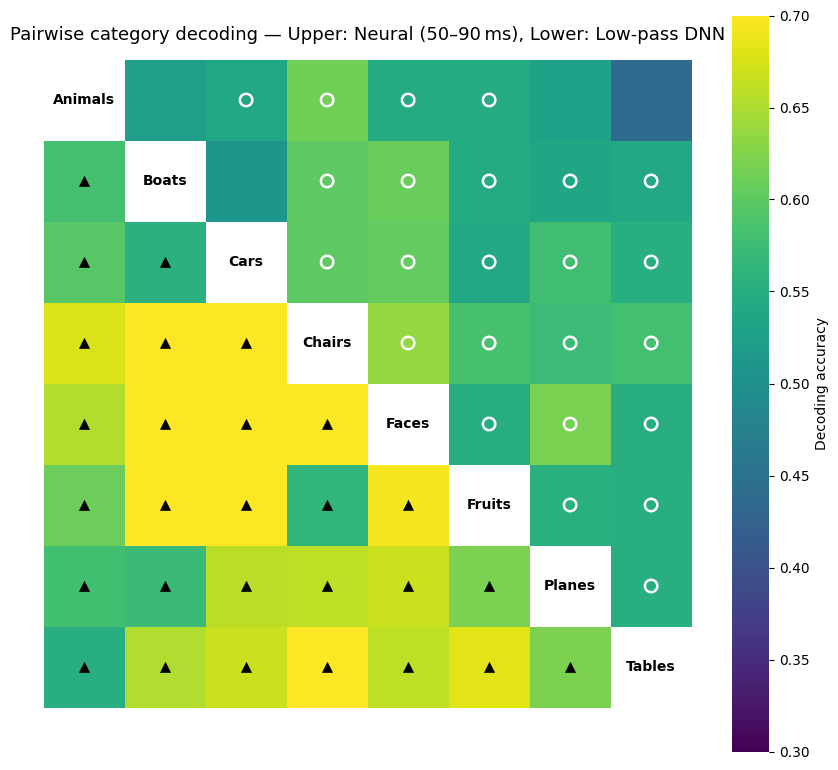

In [ ]:
# ========================== Pairwise Category Decoding ========================
import re, os
from pathlib import Path, PurePath
from itertools import combinations
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# --- IO / Paths you already had somewhere above ---
# Expect these to be defined: meta_downloaded_path, even_downloaded_path, odd_downloaded_path
FIG_DIR = Path("Figures"); FIG_DIR.mkdir(exist_ok=True, parents=True)

# ---------- Load & filter metadata ----------
meta = pd.read_csv(meta_downloaded_path)
meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)
valid_idx = np.arange(640, len(meta))
meta = meta.iloc[valid_idx].reset_index(drop=True)

# ---------- Helpers ----------
def flatten(data, t_idx):
    data = data[:, :, t_idx]
    return data.reshape(data.shape[0], -1)

def decode_pair(cat1, cat2, X_flat, labels, obj_names):
    """
    Pairwise decoding with leave‑one‑object‑per‑category out.
    Aggregates per‑trial probabilities across all (o1,o0) test folds.
    """
    mask_pair  = (labels == cat1) | (labels == cat2)
    X_pair_all = X_flat[mask_pair]
    y_pair_all = (labels[mask_pair] == cat1).astype(int)
    obj_pair   = obj_names[mask_pair]

    # PCA fitted outside pair images to avoid leakage
    train_mask_for_pca = (labels != cat1) & (labels != cat2)
    pca_global = PCA(n_components=50, random_state=42).fit(X_flat[train_mask_for_pca])

    n_pair = len(X_pair_all)
    sum_pos  = np.zeros(n_pair, dtype=float)
    sum_corr = np.zeros(n_pair, dtype=float)
    counts   = np.zeros(n_pair, dtype=int)

    objs1 = np.unique(obj_pair[y_pair_all == 1])
    objs0 = np.unique(obj_pair[y_pair_all == 0])

    clf = LogisticRegression(max_iter=500, solver="lbfgs", random_state=42)

    for o1 in objs1:
        for o0 in objs0:
            te_mask = (obj_pair == o1) | (obj_pair == o0)
            tr_mask = ~te_mask
            if tr_mask.sum() == 0 or te_mask.sum() == 0:
                continue

            X_tr = pca_global.transform(X_pair_all[tr_mask])
            X_te = pca_global.transform(X_pair_all[te_mask])
            y_tr = y_pair_all[tr_mask]
            y_te = y_pair_all[te_mask]

            clf.fit(X_tr, y_tr)
            proba_pos = clf.predict_proba(X_te)[:, 1]  # P(class==cat1)
            proba_corr = np.where(y_te == 1, proba_pos, 1 - proba_pos)

            idx_te_within_pair = np.flatnonzero(te_mask)
            sum_pos[idx_te_within_pair]  += proba_pos
            sum_corr[idx_te_within_pair] += proba_corr
            counts[idx_te_within_pair]   += 1

    valid = counts > 0
    if valid.sum() == 0:
        global_probs = np.full(len(labels), np.nan)
        global_probs[mask_pair] = np.nan
        return (cat1, cat2, np.nan, np.nan, global_probs)

    mean_pos  = np.full(n_pair, np.nan);  mean_pos[valid]  = sum_pos[valid] / counts[valid]
    mean_corr = np.full(n_pair, np.nan);  mean_corr[valid] = sum_corr[valid] / counts[valid]

    preds = (mean_pos[valid] >= 0.5).astype(int)
    acc   = (preds == y_pair_all[valid]).mean()
    k     = int(acc * valid.sum())
    pval  = binomtest(k, n=valid.sum(), p=0.5, alternative="greater").pvalue

    global_probs = np.full(len(labels), np.nan)
    global_probs[mask_pair] = mean_corr
    return (cat1, cat2, acc, pval, global_probs)

def parallel_decoding(X_flat, labels_cat, objects, cat_pairs):
    """Decode every category pair in parallel; return matrices and per-trial means."""
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(decode_pair)(c1, c2, X_flat, labels_cat, objects)
        for c1, c2 in cat_pairs
    )

    acc  = {(c1, c2): a for c1, c2, a, _, _ in results}
    pval = {(c1, c2): p for c1, c2, _, p, _ in results}
    probs= {(c1, c2): pr for c1, c2, _, _, pr in results}

    prob_matrix = np.stack([probs[pair] for pair in cat_pairs], axis=1)
    mean_trial  = np.nanmean(prob_matrix, axis=1)

    # FDR over all pairs
    p_vals = np.array([pval[pair] for pair in cat_pairs])
    _, q, _, _ = multipletests(p_vals, method="fdr_bh")
    qdict = {pair: qv for pair, qv in zip(cat_pairs, q)}

    categories = np.unique(labels_cat)
    nC = len(categories)
    A  = np.full((nC, nC), np.nan)
    S  = np.zeros((nC, nC), bool)
    for (c1, c2) in cat_pairs:
        i = np.where(categories == c1)[0][0]
        j = np.where(categories == c2)[0][0]
        if i < j:
            A[i, j] = acc[(c1, c2)]
            S[i, j] = qdict[(c1, c2)] < 0.05
    return A, S, probs, mean_trial

def plot_combined_upper_neural_lower_dnn(A_neu, S_neu, A_dnn, S_dnn, categories,
                                         vmin=.3, vmax=.7, cmap="viridis"):
    """
    Build one matrix where:
      - Upper triangle (i<j): Neural accuracies
      - Lower triangle (i>j): DNN accuracies
      - Diagonal: blank (with category names written inside)
    Significance:
      - Neural: open white circle '◦' on upper cells with q<.05
      - DNN   : filled triangle '▲' on lower cells with q<.05
    """
    nC = len(categories)
    C   = np.full((nC, nC), np.nan)
    SigN= np.zeros((nC, nC), bool)
    SigD= np.zeros((nC, nC), bool)

    # Upper: Neural (already stored on upper in A_neu)
    if A_neu is not None:
        upper = ~np.isnan(A_neu)
        C[upper] = A_neu[upper]
        SigN[upper] = S_neu[upper]

    # Lower: DNN — our A_dnn is also upper-only, so mirror into lower
    if A_dnn is not None:
        upper = ~np.isnan(A_dnn)
        # write to the symmetric lower cells
        C.T[upper] = A_dnn[upper]
        SigD.T[upper] = S_dnn[upper]

    # Heatmap without ticks; diagonal left NaN for text overlay
    fig, ax = plt.subplots(figsize=(8.4, 7.8))
    mask = np.isnan(C)
    hm = sns.heatmap(C, vmin=vmin, vmax=vmax, cmap=cmap, mask=mask,
                     cbar=True, square=True, ax=ax,
                     xticklabels=False, yticklabels=False,
                     cbar_kws={"label": "Decoding accuracy"})

    # Diagonal category names
    for i, cat in enumerate(categories):
        ax.text(i + 0.5, i + 0.5, str(cat),
                ha="center", va="center", fontsize=10, fontweight="bold",
                color="black", rotation=0)

    # Significance overlays
    # Neural (upper): open white circles
    for i in range(nC):
        for j in range(i+1, nC):
            if SigN[i, j]:
                ax.scatter(j + 0.5, i + 0.5, s=80,
                           facecolors="none", edgecolors="white", linewidths=1.8)

    # DNN (lower): filled triangles
    for i in range(1, nC):
        for j in range(0, i):
            if SigD[i, j]:
                ax.scatter(j + 0.5, i + 0.5, s=52, marker="^",
                           facecolors="black", edgecolors="black", linewidths=0.5)

    # Borders and labels
    ax.set_title("Pairwise category decoding — Upper: Neural (50–90 ms), Lower: Low‑pass DNN",
                 pad=14, fontsize=13)

    # Custom legend
    from matplotlib.lines import Line2D
    legend_elems = [
        Line2D([0], [0], marker='o', linestyle='None', markersize=8,
               markerfacecolor='none', markeredgecolor='white', label='Neural q<.05'),
        Line2D([0], [0], marker='^', linestyle='None', markersize=7,
               markerfacecolor='black', markeredgecolor='black', label='DNN q<.05'),
    ]
    plt.tight_layout()
    out_svg = FIG_DIR / "pairwise_combined_upper_neural_lower_dnn.svg"
    out_png = FIG_DIR / "pairwise_combined_upper_neural_lower_dnn.png"
    out_pdf = FIG_DIR / "pairwise_combined_upper_neural_lower_dnn.pdf"
    fig.savefig(out_svg); fig.savefig(out_png, dpi=300); fig.savefig(out_pdf)
    print(f"Saved:\n  {out_png}\n  {out_svg}\n  {out_pdf}")
    plt.show()

# ------------------------------ Run pairwise decoding -------------------------
meta_df = meta.copy()
labels_cat = meta_df["category_name"].values
objects    = meta_df["object_name"].values
categories_unique = np.unique(labels_cat)
cat_pairs  = list(combinations(categories_unique, 2))

A_neu = S_neu = A_dnn = Sig_dnn = None

# Neural early features
if Path(even_downloaded_path).exists() and Path(odd_downloaded_path).exists():
    print("Pairwise category decoding — Neural (50–90 ms)…")
    rate_even = np.load(even_downloaded_path, allow_pickle=True)
    rate_odd  = np.load(odd_downloaded_path,  allow_pickle=True)
    even_raw, odd_raw = rate_even, rate_odd
    early_idx = slice(5, 9)  # 50–90 ms
    X_early = flatten((even_raw[valid_idx] + odd_raw[valid_idx]) / 2, early_idx)
    A_neu, S_neu, _, _ = parallel_decoding(X_early, labels_cat, objects, cat_pairs)
else:
    print("Skipping Neural pairwise decoding (missing spike files).")

# Low‑pass DNN features (pooled across nets if present)
feature_dir = Path("deepNetFeatures")
if feature_dir.exists():
    print("Pairwise category decoding — Low‑pass DNN …")
    PKL_RE = re.compile(r"^(?P<net>.*?)_features_high_variation_lowpass\.pkl$")
    lowpass_pkls = [p for p in feature_dir.glob("*.pkl") if PKL_RE.match(p.name)]
    if not lowpass_pkls:
        print(f"No low‑pass DNN feature files found in {feature_dir}.")
    else:
        def process_net(pkl_path, meta_df):
            with open(pkl_path, "rb") as fh:
                feats = np.load(fh, allow_pickle=True)
            img_names = [PurePath(p).stem for p in feats["image_names"]]
            base = meta_df["filename"].str.replace(r"\.\w+$", "", regex=True)
            idx = np.array([img_names.index(b) for b in base])
            X = feats["penultimate"][idx]
            if X.ndim > 2:
                X = X.reshape(X.shape[0], -1)
            return X

        n_trials = len(labels_cat)
        sum_prob = np.zeros((n_trials, len(cat_pairs)), dtype=float)
        cnt_prob = np.zeros((n_trials, len(cat_pairs)), dtype=int)

        for pkl in lowpass_pkls:
            print(f"   · decoding {pkl.name}")
            X_net = process_net(pkl, meta_df)
            A_tmp, S_tmp, probs_net, _ = parallel_decoding(X_net, labels_cat, objects, cat_pairs)
            prob_matrix = np.stack([probs_net[pair] for pair in cat_pairs], axis=1)
            valid = ~np.isnan(prob_matrix)
            sum_prob[valid] += prob_matrix[valid]
            cnt_prob[valid] += 1

        mean_prob_dnn = np.where(cnt_prob > 0, sum_prob / cnt_prob, np.nan)
        np.save("Lowpass_probs.npy", mean_prob_dnn)
        np.save("mean_predprob_per_trial_lowpass.npy", np.nanmean(mean_prob_dnn, axis=1))

        # Build accuracy+significance matrices from pooled probs (upper only, mirror later)
        A_dnn     = np.full((len(categories_unique), len(categories_unique)), np.nan)
        Sig_dnn   = np.zeros_like(A_dnn, dtype=bool)
        pair_p    = []
        pair_idx  = []

        for col, (c1, c2) in enumerate(cat_pairs):
            rows = np.where((labels_cat == c1) | (labels_cat == c2))[0]
            pvec = mean_prob_dnn[rows, col]
            ok   = ~np.isnan(pvec)
            n    = ok.sum()
            if n == 0:
                pair_p.append(1.0); pair_idx.append((c1, c2))
                continue
            k = int((pvec[ok] >= 0.5).sum())
            pair_p.append(binomtest(k, n=n, p=0.5, alternative="greater").pvalue)
            pair_idx.append((c1, c2))
            i = np.where(categories_unique == c1)[0][0]
            j = np.where(categories_unique == c2)[0][0]
            if i < j:
                A_dnn[i, j] = k / n

        _, qvals, _, _ = multipletests(np.array(pair_p), method="fdr_bh")
        for (c1, c2), qv in zip(pair_idx, qvals):
            i = np.where(categories_unique == c1)[0][0]
            j = np.where(categories_unique == c2)[0][0]
            if i < j and qv < 0.05:
                Sig_dnn[i, j] = True
else:
    print("Skipping DNN pairwise decoding (deepNetFeatures folder not found).")

plot_combined_upper_neural_lower_dnn(A_neu, S_neu, A_dnn, Sig_dnn, categories_unique)

## Illustration of methodology

Saved:
  Figures/method_LOO_train_test_grid_generalisation_LSF.png 
  Figures/method_LOO_train_test_grid_generalisation_LSF.svg


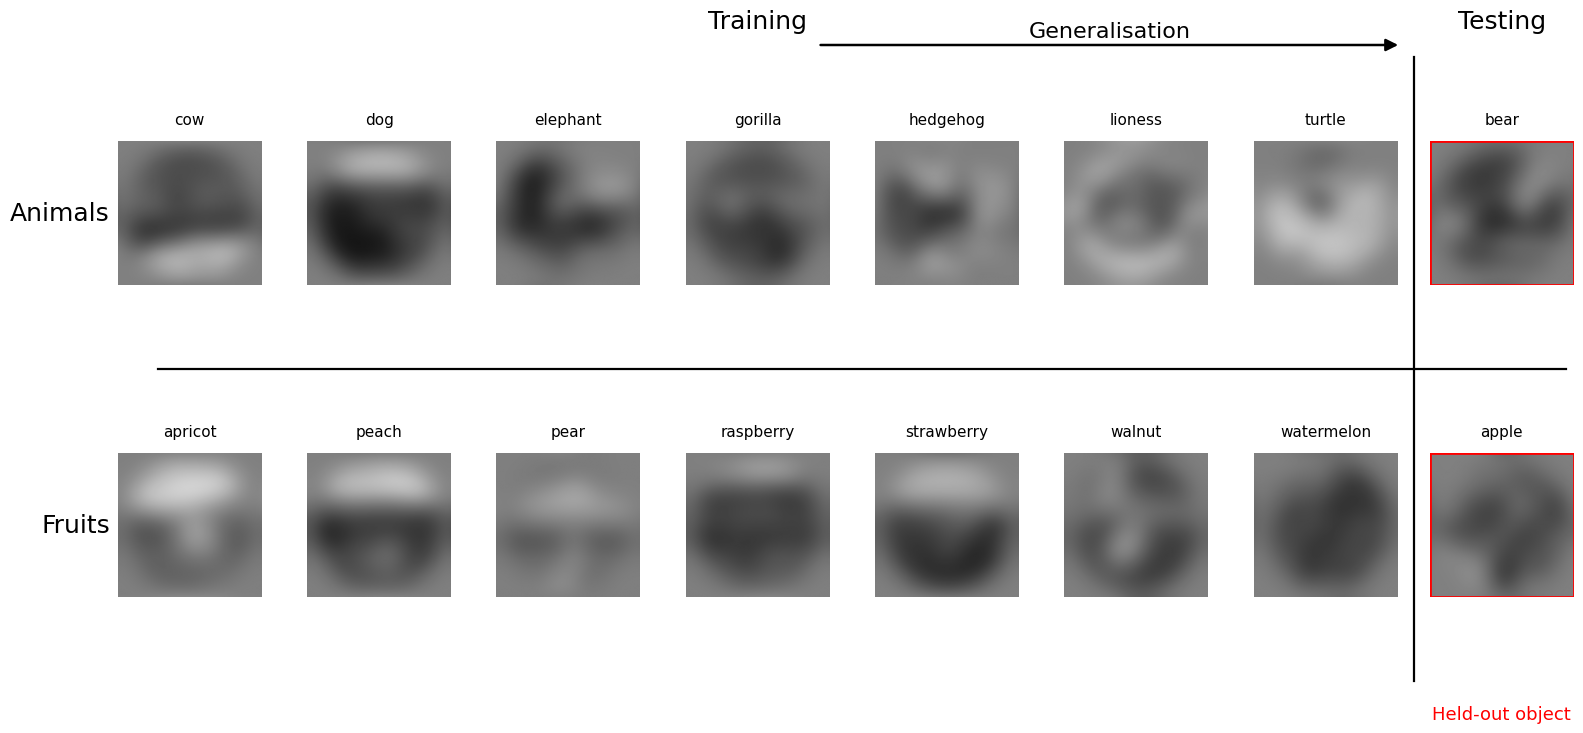

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Generalisation panel (LSF-blurred): leave-one-object-per-category out
# ─────────────────────────────────────────────────────────────────────────────

import io, zipfile, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Rectangle
from matplotlib.lines import Line2D
from PIL import Image, ImageOps

plt.rcParams.update({"svg.fonttype": "none"})  # keep text as text in SVG

# ------------------------- Config -------------------------
DOWNLOAD_DIR = Path("downloads")
FIG_DIR      = Path("Figures")
META_CSV     = DOWNLOAD_DIR / "hvm_public_extended_meta.csv"
ZIP_HIGH     = DOWNLOAD_DIR / "high_variation_stimuli.zip"

CAT1, CAT2 = "Animals", "Fruits"
HOLDOUT1, HOLDOUT2 = None, None

THUMB_SIZE      = (140, 140)
MIN_TRAIN_COLS  = 6
FIGSIZE         = (16, 8)

# LSF filter params
FOV_DEG         = 8.0
CUTOFF_CPD      = 0.5
ATTEN_DB_ATCUT  = -20

# ------------------------- IO helpers -------------------------
def open_zip(zip_path: Path) -> zipfile.ZipFile:
    if not zip_path.exists():
        raise FileNotFoundError(f"Missing archive: {zip_path}")
    return zipfile.ZipFile(zip_path, "r")

def load_meta_high_variation(meta_csv: Path) -> pd.DataFrame:
    meta = pd.read_csv(meta_csv)
    meta["base"] = meta["filename"].str.replace(r"\.\w+$", "", regex=True)
    # Keep high-variation subset (skip first 640 background-only rows)
    return meta.iloc[np.arange(640, len(meta))].reset_index(drop=True)

def load_grayscale_from_zip(zf: zipfile.ZipFile, base_stem: str, resize=THUMB_SIZE):
    target = f"{base_stem}.png"
    for name in zf.namelist():
        if name.endswith(target):
            with zf.open(name) as fh:
                im = Image.open(io.BytesIO(fh.read())).convert("L")
                im = ImageOps.contain(im, resize)
                return np.asarray(im)
    return None

def representative_blurred(df_subset: pd.DataFrame, category: str, object_name: str, zf: zipfile.ZipFile):
    rows = df_subset.query("category_name == @category and object_name == @object_name")
    if rows.empty:
        return None
    base = rows.iloc[0]["base"]
    arr  = load_grayscale_from_zip(zf, base, resize=THUMB_SIZE)
    if arr is None:
        return None
    lp   = m_pathway_filter_gaussian(arr.astype(float),
                                     cutoff_cpd=CUTOFF_CPD,
                                     fov_deg=FOV_DEG,
                                     atten_dB_at_cut=ATTEN_DB_ATCUT)
    return np.clip(lp, 0, 255).astype(np.uint8)

# ---------------------- Build split & images -----------------------
meta_hv = load_meta_high_variation(META_CSV)
with open_zip(ZIP_HIGH) as zf:
    avail = meta_hv["category_name"].unique().tolist()
    if CAT1 not in avail or CAT2 not in avail:
        raise ValueError(f"Categories must be among {avail}, got ({CAT1}, {CAT2}).")

    objs1 = sorted(meta_hv.query("category_name == @CAT1")["object_name"].unique())
    objs2 = sorted(meta_hv.query("category_name == @CAT2")["object_name"].unique())
    if HOLDOUT1 is None: HOLDOUT1 = objs1[0]
    if HOLDOUT2 is None: HOLDOUT2 = objs2[0]
    if HOLDOUT1 not in objs1: raise ValueError(f"holdout1 '{HOLDOUT1}' not in {objs1}")
    if HOLDOUT2 not in objs2: raise ValueError(f"holdout2 '{HOLDOUT2}' not in {objs2}")

    pair_mask = meta_hv["category_name"].isin([CAT1, CAT2])
    df_pair   = meta_hv[pair_mask].copy()
    is_test   = ((df_pair["category_name"] == CAT1) & (df_pair["object_name"] == HOLDOUT1)) | \
                ((df_pair["category_name"] == CAT2) & (df_pair["object_name"] == HOLDOUT2))
    df_test, df_train = df_pair[is_test], df_pair[~is_test]

    train_imgs_c1 = {}
    for o in objs1:
        if o == HOLDOUT1: continue
        im = representative_blurred(df_train, CAT1, o, zf)
        if im is not None: train_imgs_c1[o] = im

    train_imgs_c2 = {}
    for o in objs2:
        if o == HOLDOUT2: continue
        im = representative_blurred(df_train, CAT2, o, zf)
        if im is not None: train_imgs_c2[o] = im

    test_img_c1 = {}
    im = representative_blurred(df_test, CAT1, HOLDOUT1, zf)
    if im is not None: test_img_c1[HOLDOUT1] = im

    test_img_c2 = {}
    im = representative_blurred(df_test, CAT2, HOLDOUT2, zf)
    if im is not None: test_img_c2[HOLDOUT2] = im

# ----------------------------- Plot helpers ------------------------
def label_above(fig, x_center, y_top, text, fontsize=11, pad=0.008):
    """Place a label above a thumbnail using figure coordinates."""
    fig.text(x_center, y_top + pad, text, ha="center", va="bottom", fontsize=fontsize)

def place_training_row(fig, images_dict, band_bottom, band_top,
                       area_left, area_right, min_cols=MIN_TRAIN_COLS,
                       box_w=0.09, box_h=0.20):
    """Place thumbnails within a horizontal band [band_bottom, band_top] (figure coords)."""
    keys = sorted(images_dict.keys())
    if not keys: return
    # keep a safety pad so images do not touch the separation line
    vpad = 0.015
    y_center = (band_bottom + band_top) / 2.0
    box_h = min(box_h, (band_top - band_bottom) - 2*vpad)
    y0 = y_center - box_h/2.0

    n = len(keys)
    cols = max(min_cols, n)
    xs_all = np.linspace(area_left + 0.02, area_right - 0.02, cols)
    if n < cols:
        start = (cols - n)//2
        xs = xs_all[start:start+n]
    else:
        xs = np.linspace(area_left + 0.02, area_right - 0.02, n)

    for x, k in zip(xs, keys):
        x0 = x - box_w/2.0
        ax = fig.add_axes([x0, y0, box_w, box_h])
        ax.imshow(images_dict[k], cmap="gray", vmin=0, vmax=255)
        ax.set_axis_off()
        label_above(fig, x, y0 + box_h, k, fontsize=11)

def place_test_single(fig, image_dict, x_center, band_bottom, band_top,
                      box_w=0.09, box_h=0.20):
    if not image_dict: return
    vpad = 0.015
    y_center = (band_bottom + band_top) / 2.0
    box_h = min(box_h, (band_top - band_bottom) - 2*vpad)
    y0 = y_center - box_h/2.0

    (name, im), = image_dict.items()
    ax = fig.add_axes([x_center - box_w/2.0, y0, box_w, box_h])
    ax.imshow(im, cmap="gray", vmin=0, vmax=255)
    ax.set_axis_off()
    label_above(fig, x_center, y0 + box_h, name, fontsize=11)
    ax.add_patch(Rectangle((0,0),1,1, transform=ax.transAxes,
                           lw=2, edgecolor="red", facecolor="none"))

# ----------------------------- Plot -------------------------------
fig = plt.figure(figsize=FIGSIZE)

# Full-figure coordinates
L, R = 0.10, 0.98
B, T = 0.12, 0.90

left_w, right_w = 0.75, 0.18
xsplit = L + left_w
mid    = (T + B) / 2.0

# Draw separation lines in FIGURE COORDINATES (no overlap issues)
fig.add_artist(Line2D([L, R], [mid, mid], lw=1.6, color="black", zorder=5, transform=fig.transFigure))
fig.add_artist(Line2D([xsplit +.035, xsplit +.035], [B, T], lw=1.6, color="black", zorder=5, transform=fig.transFigure))

# Headers (figure coords)
fig.text(L + left_w/2.0, T + 0.03, "Training", ha="center", va="bottom", fontsize=18)
fig.text(xsplit + right_w/2.0, T + 0.03, "Testing",  ha="center", va="bottom", fontsize=18)

# Arrow + label (figure coords)
xs, xe = L + left_w*0.55, xsplit + right_w*0.15
fig.patches.append(FancyArrowPatch((xs, T + 0.015), (xe, T + 0.015),
                                   arrowstyle='-|>', mutation_scale=18, lw=1.8,
                                   color="black", transform=fig.transFigure))
fig.text((xs + xe)/2.0, T + 0.02, "Generalisation", ha="center", va="bottom", fontsize=16)

# Category labels (figure coords)
fig.text(L - 0.03, (T + mid)/2.0, CAT1, ha="right", va="center", fontsize=18)
fig.text(L - 0.03, (mid + B)/2.0, CAT2, ha="right",  va="center", fontsize=18)

# Training rows (blurred thumbnails) — use bands with padding to avoid the mid line
place_training_row(fig, train_imgs_c1, band_bottom=mid+0.02, band_top=T-0.02,
                   area_left=L, area_right=xsplit, min_cols=MIN_TRAIN_COLS)
place_training_row(fig, train_imgs_c2, band_bottom=B+0.02,  band_top=mid-0.02,
                   area_left=L, area_right=xsplit, min_cols=MIN_TRAIN_COLS)

# Test column (blurred held-out)
x_center = xsplit + right_w/2.0
place_test_single(fig, test_img_c1, x_center=x_center,
                  band_bottom=mid+0.02, band_top=T-0.02)
place_test_single(fig, test_img_c2, x_center=x_center,
                  band_bottom=B+0.02,  band_top=mid-0.02)

# Legend
fig.text(x_center, B - 0.03, "Held-out object", ha="center", va="top", fontsize=13, color="red")

FIG_DIR.mkdir(parents=True, exist_ok=True)
out_png = FIG_DIR / "method_LOO_train_test_grid_generalisation_LSF.png"
out_svg = FIG_DIR / "method_LOO_train_test_grid_generalisation_LSF.svg"
fig.savefig(out_png, dpi=200, bbox_inches="tight")
fig.savefig(out_svg, bbox_inches="tight")
print("Saved:\n ", out_png, "\n ", out_svg)

# Distance to object prototype

## Illustration of hypothesis

Figure saved to Figures/schema_images_generated.jpeg


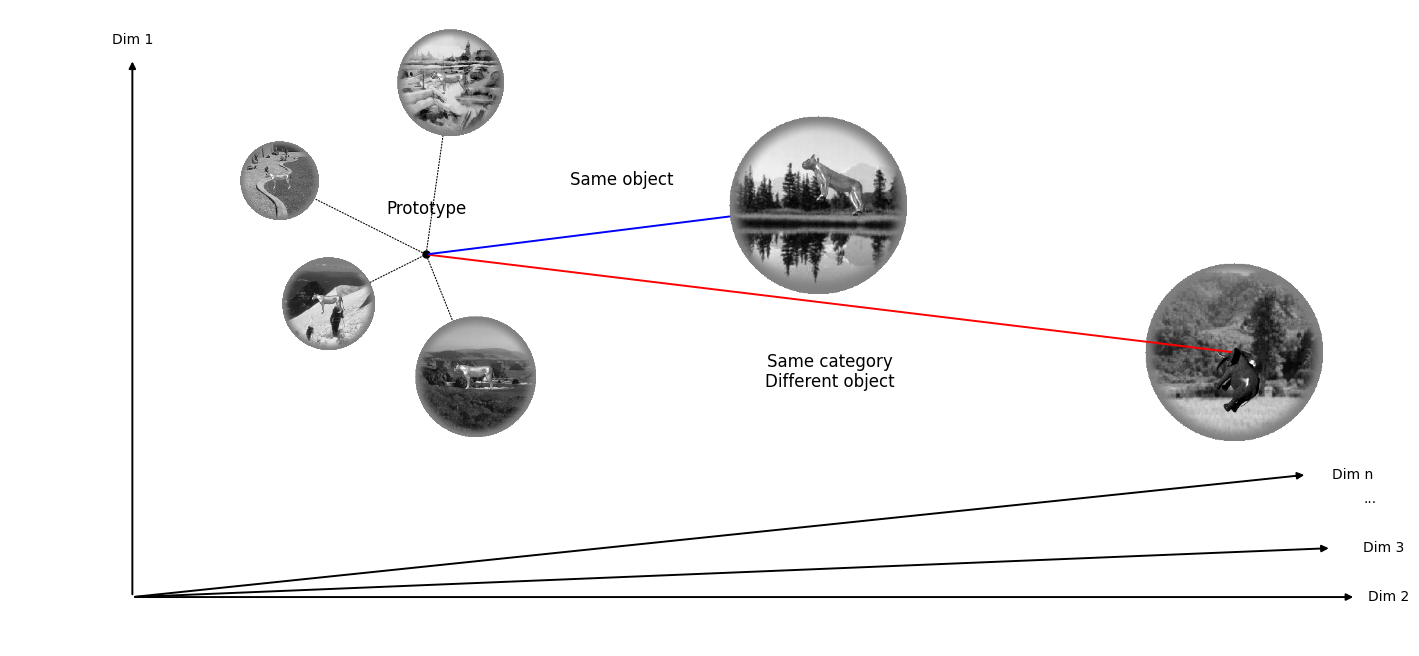

In [ ]:
CATEGORY        = "animal"      # one of meta.category_name
OBJ_MAIN        = "lioness"      # object shown in LOW + HIGH-same-object
OBJ_OTHER       = "elephant"     # another object from the same category

# 2-D coordinates (Dim-1 vs Dim-50 plane, arbitrary units)
PROTOTYPE_PT    = (1.2, 1.4)
LOW_COORDS      = [(0.6, 1.70), (1.3, 2.1), (0.8, 1.20), (1.4, .9)]
HIGH_SAME_COORD = (2.8, 1.60)
HIGH_DIFF_COORD = (4.5, 1)

# Relative image size
LOW_ZOOMS        = (0.22, .3, 0.26, 0.34)
HIGH_ZOOMS       = (.5, 0.5)

# Data file names (change if yours differ)
META_CSV        = "downloads/hvm_public_extended_meta.csv"
ZIP_LOW         = "downloads/background_variations_images.zip"
ZIP_HIGH        = "downloads/high_variation_stimuli.zip"
OUT_FIG         = "Figures/schema_images_generated.jpeg"

# How to treat pixels outside the circular aperture: "alpha" (transparent) or "white"
APERTURE_MODE   = "alpha"   # change to "white" if you prefer white background
APERTURE_RADIUS = 128       # images are 256x256, circle centered

# ======================================================================
import io, random, zipfile, os, sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import FancyBboxPatch
from PIL import Image
import numpy as np
np.random.seed(42)

# ---------- Helper: load PNG by SHA-1 inside a zip (search subfolders) --
def load_image_from_zip(zfile: zipfile.ZipFile, sha_png: str):
    for name in zfile.namelist():
        if name.endswith(sha_png):
            with zfile.open(name) as f:
                return Image.open(io.BytesIO(f.read()))
    return None

# ---------- Aperture processing: make outside-circle transparent/white ------
def apply_circular_aperture(img: Image.Image,
                            radius: int = APERTURE_RADIUS,
                            mode: str = APERTURE_MODE) -> Image.Image:
    """
    Ensures RGBA and sets alpha=0 (or RGB=255) for pixels outside a centered circle.
    Assumes square 256x256, but works for any square image by using min dimension.
    """
    img = img.convert("RGBA")
    arr = np.array(img)
    h, w = arr.shape[:2]
    cx, cy = w // 2, h // 2
    r = min(radius, cx, cy)

    # boolean mask for pixels INSIDE the circle
    yy, xx = np.ogrid[:h, :w]
    inside = (xx - cx) ** 2 + (yy - cy) ** 2 <= r * r

    if mode.lower() == "alpha":
        # punch out: transparent outside
        arr[~inside, 3] = 0
    else:
        # white outside, keep alpha=255
        arr[~inside, :3] = 255
        arr[~inside, 3] = 255

    return Image.fromarray(arr)

# ---------- Load metadata & archives -----------------------------------
if not os.path.exists(META_CSV):
    sys.exit(f"Metadata file '{META_CSV}' not found.")
meta = pd.read_csv(META_CSV)

try:
    zip_low  = zipfile.ZipFile(ZIP_LOW)
    zip_high = zipfile.ZipFile(ZIP_HIGH)
except FileNotFoundError as e:
    sys.exit(e)

# Helper to embed image
def add_image(img, xy, zoom):
    if img is None:
        rect = FancyBboxPatch((xy[0]-0.14, xy[1]-0.14), 0.28, 0.28,
                              boxstyle="round,pad=0.02", edgecolor='red', facecolor='white')
        ax.add_patch(rect)
        ax.text(*xy, "MISSING", ha='center', va='center', fontsize=6)
        return
    # Matplotlib can take a PIL image; keep frame off to respect alpha
    ab = AnnotationBbox(OffsetImage(img, zoom=zoom), xy, frameon=False, pad=0)
    ax.add_artist(ab)

# ---------- Pick exemplar filenames ------------------------------------
def pick_images(obj_name, variation, k):
    rows = meta[(meta.object_name == obj_name) & (meta.variation == variation)]
    if len(rows) < k:
        sys.exit(f"Not enough images for '{obj_name}', variation {variation}")
    return random.sample(rows["filename"].tolist(), k)

sha_low  = pick_images(OBJ_MAIN, 0, 4)       # four low-variation
sha_same = pick_images(OBJ_MAIN, 3, 1)[0]    # same object, high-variation
sha_diff = pick_images(OBJ_OTHER, 3, 1)[0]   # diff object, high-variation

# ---------- Load PIL images + apply aperture ---------------------------
def get_img(sha1):
    im = (load_image_from_zip(zip_low,  sha1)
          or load_image_from_zip(zip_high, sha1))
    if im is None:
        return None
    return apply_circular_aperture(im)

img_low   = [get_img(s) for s in sha_low]
img_same  = get_img(sha_same)
img_diff  = get_img(sha_diff)

# ---------- Build figure -----------------------------------------------
fig, ax = plt.subplots(figsize=(18, 10))
ax.set_aspect('equal')
ax.set_xlim(-0.5, 5.2)
ax.set_ylim(-0.2, 2.4)
ax.axis('off')

# Axes arrows
ax.annotate("", xy=(0.0, 2.2), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(0, 2.25, "Dim 1", va='bottom', ha='center')

ax.annotate("", xy=(5.0, 0.0), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(5.05, 0, "Dim 2", va='center', ha='left')

ax.annotate("", xy=(4.9, .2), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(5.03, .2, "Dim 3", va='center', ha='left')

ax.text(5.03, .4, "...", va='center', ha='left')

ax.annotate("", xy=(4.8, .5), xytext=(0, 0),
            arrowprops=dict(arrowstyle='-|>', lw=1.4, color='black'))
ax.text(4.9, .5, "Dim n", va='center', ha='left')

# High-variation different object
mid_diff = ((PROTOTYPE_PT[0]+HIGH_DIFF_COORD[0])/2,
            (PROTOTYPE_PT[1]+HIGH_DIFF_COORD[1])/2)
add_image(img_diff, HIGH_DIFF_COORD, HIGH_ZOOMS[1])
ax.annotate("", xy=HIGH_DIFF_COORD, xytext=PROTOTYPE_PT,
            arrowprops=dict(arrowstyle='-', lw=1.4, color='r'))

# Prototype
ax.plot(*PROTOTYPE_PT, 'ko', markersize=5)
ax.text(PROTOTYPE_PT[0], PROTOTYPE_PT[1] + 0.15, "Prototype",
        ha='center', va='bottom', fontsize=12)

# Low-variation images (dotted connectors)
for coord, img, LOW_ZOOM in zip(LOW_COORDS, img_low, LOW_ZOOMS):
    ax.annotate("", xy=PROTOTYPE_PT, xytext=coord,
                arrowprops=dict(lw=0.8, linestyle='dotted',
                                arrowstyle='-', color='black'))
    add_image(img, coord, LOW_ZOOM)

# High-variation same object
ax.annotate("", xy=HIGH_SAME_COORD, xytext=PROTOTYPE_PT,
            arrowprops=dict(arrowstyle='-', lw=1.4, color='b'))
mid_same = ((PROTOTYPE_PT[0]+HIGH_SAME_COORD[0])/2,
            (PROTOTYPE_PT[1]+HIGH_SAME_COORD[1])/2)
add_image(img_same, HIGH_SAME_COORD, HIGH_ZOOMS[0])
ax.text(mid_same[0], mid_same[1]+0.17, "Same object",
        ha='center', va='bottom', fontsize=12)

ax.text(mid_diff[0], mid_diff[1]-0.20,
        "Same category\nDifferent object", ha='center', va='top', fontsize=12)

# ---------- Save --------------------------------------------------------
fig.savefig(OUT_FIG, dpi=600, bbox_inches='tight')
print("Figure saved to", OUT_FIG)

## Analysis

Loading metadata …
Loading neural data …
Computing TD (early 50–90 ms) …
Early TD grand mean = 0.0141, p = 0.1536
Computing TD (late 100–200 ms) …
Late  TD grand mean = 0.0141, p = 0.0147
Figure saved to Figures/template_distance_early_late.(png|svg|pdf)


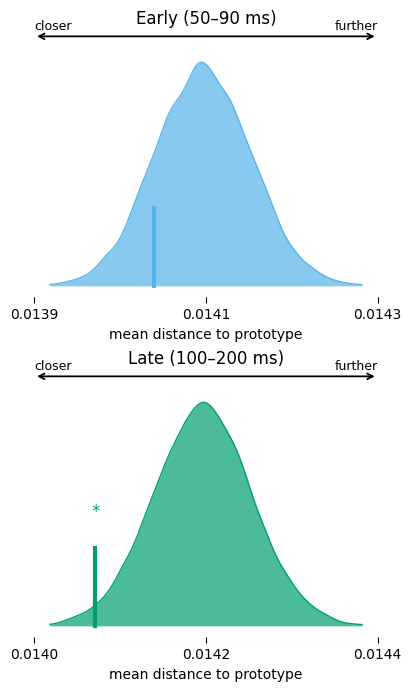

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Early & Late Template Distance (TD): two rotated-density subplots (stacked)
# ─────────────────────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import jit

# ------------------------------ Paths & Config ------------------------------
META_PATH = 'downloads/hvm_public_extended_meta.csv'
EVEN_PATH = 'downloads/Spike_count_even_sessions.npy'
ODD_PATH  = 'downloads/Spike_count_odd_sessions.npy'

FIG_DIR   = 'Figures'
N_PERM    = 10_000
RNG_SEED  = 42

# Color codes: early = blue, late = green
PALETTE_EARLY = {'Perm': '#56B4E9', 'Obs': '#56B4E9'}
PALETTE_LATE  = {'Perm': '#009E73', 'Obs': '#009E73'}

plt.rcParams.update({"svg.fonttype": "none"})  # keep text editable in SVG
os.makedirs(FIG_DIR, exist_ok=True)

# ------------------------------ Helpers -------------------------------------
@jit
def sqeucl(mat: jnp.ndarray, vec: jnp.ndarray) -> jnp.ndarray:
    """Row-wise mean-squared Euclidean distance to vec."""
    return jnp.mean((mat - vec) ** 2, axis=1)

def q_to_stars(q: float) -> str:
    if q < 1e-4: return '****'
    if q < 1e-3: return '***'
    if q < 1e-2: return '**'
    if q < 5e-2: return '*'
    return ''

def _set_three_ticks(ax):
    """Force exactly three evenly spaced xticks on current x-limits."""
    xmin, xmax = ax.get_xlim()
    ticks = np.linspace(xmin, xmax, 3)
    ax.set_xticks(ticks)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

def plot_rotated_density_single(ax, title, obs, null_dist, p_val, xlabel, palette):
    """One rotated-density panel (with three xticks)."""
    # KDE grid on 0.1–99.9 % range (light truncation)
    p_lo, p_hi = np.percentile(null_dist, [0.1, 99.9])
    pad = 0.02 * (p_hi - p_lo)
    x_g = np.linspace(p_lo - pad, p_hi + pad, 200)
    dens = gaussian_kde(null_dist)(x_g)
    dens[dens < 0.005 * dens.max()] = 0
    max_d = dens.max() or 1e-8

    # density + observed line
    ax.fill_between(x_g, 0, dens, color=palette['Perm'], alpha=.7, lw=0)
    ax.plot(x_g, dens, color=palette['Perm'], lw=1)
    ln = 0.35 * max_d
    ax.plot([obs, obs], [0, ln], color=palette['Obs'], lw=3)

    # significance stars
    stars = q_to_stars(p_val)
    if stars:
        ax.text(obs, ln + 0.12 * max_d, stars, ha='center', va='bottom',
                fontsize=12, color=palette['Obs'])

    # cosmetics
    ax.set_yticks([])
    ax.tick_params(axis='y', left=False, labelleft=False)
    for s in ax.spines.values():
        s.set_visible(False)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.tick_params(axis='x', bottom=True, labelbottom=True, length=4)
    ax.set_title(title, fontsize=12, pad=20)
    _set_three_ticks(ax)

    # horizontal “closer↔further” guide
    arrow_y = 1.06
    ax.annotate('', xy=(1, arrow_y), xytext=(0, arrow_y),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle='<->', lw=1.3, color='black'),
                clip_on=False)
    ax.text(0, arrow_y + 0.015, 'closer', transform=ax.transAxes,
            ha='left', va='bottom', fontsize=9)
    ax.text(1, arrow_y + 0.015, 'further', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=9)

def compute_td_for_window(X_full: jnp.ndarray,
                          meta: pd.DataFrame,
                          rng: np.random.Generator):
    """
    Compute TD grand mean and null for a given time window directly
    in the native (channels×timebins) feature space. No dimensionality reduction.
    Templates come from low-variation exemplars (per object).
    """
    # boolean masks (accept both numeric and string encodings if present)
    var_col = meta['variation'].values
    low_var_mask  = (var_col == 0) | (var_col == 'background_only')
    high_var_mask = (var_col == 3) | (var_col == 'full_variation') | (var_col == 'full')

    # center features once (translation-invariant; does not change pairwise distances)
    Xc = X_full - jnp.mean(X_full, axis=0)

    # convenient NumPy views for metadata
    obj_all = meta['object_name'].values
    cat_all = meta['category_name'].values

    dist_true  = []
    dist_nulls = []

    # iterate over unique objects present in metadata
    for obj in pd.unique(obj_all):
        # indices for this object's LV and HV images (global)
        lv_idx = np.where(low_var_mask & (obj_all == obj))[0]
        hv_idx = np.where(high_var_mask & (obj_all == obj))[0]
        if lv_idx.size == 0 or hv_idx.size == 0:
            continue

        # template from low-variation exemplars (in centered native space)
        template = jnp.mean(Xc[lv_idx], axis=0)

        # observed distances for this object's high-variation images
        dists = np.asarray(sqeucl(Xc[hv_idx], template))
        dist_true.append(dists.mean())

        # build category-matched HV pool excluding this object
        cat = cat_all[lv_idx[0]]
        pool_mask = high_var_mask & (cat_all == cat) & (obj_all != obj)
        pool_idx = np.where(pool_mask)[0]
        if pool_idx.size == 0:
            continue
        pool_d = np.asarray(sqeucl(Xc[pool_idx], template))

        # null: resample same count as hv_idx, take mean; repeat N_PERM
        perm_means = rng.choice(pool_d, size=(N_PERM, hv_idx.size), replace=True).mean(axis=1)
        dist_nulls.append(perm_means)

    # Aggregate across objects
    dist_true  = np.array(dist_true)
    if len(dist_nulls) == 0:
        # Fallback if nothing collected
        emp_dist  = np.nan
        null_dist = np.full(N_PERM, np.nan, dtype=float)
        p_dist    = np.nan
    else:
        dist_nulls = np.vstack(dist_nulls)
        emp_dist   = dist_true.mean() if dist_true.size else np.nan
        null_dist  = dist_nulls.mean(axis=0)
        p_dist     = (null_dist <= emp_dist).mean() if np.isfinite(emp_dist) else np.nan

    return emp_dist, null_dist, p_dist

# ------------------------------ Data & Windows ------------------------------
print('Loading metadata …')
meta = pd.read_csv(META_PATH)

print('Loading neural data …')
rate = (np.load(EVEN_PATH) + np.load(ODD_PATH)) / 2.0  # trials × channels × timebins

# 10-ms bins edges (left edges): 0,10,...,190
time_edges = np.arange(0, 200, 10)

# Early window: 50–90 ms
early_bins = np.where((time_edges >= 50) & (time_edges <= 90))[0]

# Late window: 100–200 ms
late_bins  = np.where((time_edges >= 100) & (time_edges <= 200))[0]

# Flatten per window (channels × selected timebins)
X_early = rate[:, :, early_bins].reshape(rate.shape[0], -1).astype('float32')
X_late  = rate[:, :, late_bins ].reshape(rate.shape[0], -1).astype('float32')

X_early = jnp.array(X_early)
X_late  = jnp.array(X_late)

# ------------------------------ TD for both windows -------------------------
rng = np.random.default_rng(RNG_SEED)

print('Computing TD (early 50–90 ms) …')
emp_e, null_e, p_e = compute_td_for_window(X_early, meta, rng)
print(f"Early TD grand mean = {emp_e:.4f}, p = {p_e:.4g}")

print('Computing TD (late 100–200 ms) …')
emp_l, null_l, p_l = compute_td_for_window(X_late,  meta, rng)
print(f"Late  TD grand mean = {emp_l:.4f}, p = {p_l:.4g}")

# ------------------------------ Plot (stacked) ------------------------------
fig, axes = plt.subplots(2, 1, figsize=(4.0, 6.8), constrained_layout=True)

plot_rotated_density_single(
    axes[0], 'Early (50–90 ms)',
    emp_e, null_e, p_e,
    'mean distance to prototype', PALETTE_EARLY
)
plot_rotated_density_single(
    axes[1], 'Late (100–200 ms)',
    emp_l, null_l, p_l,
    'mean distance to prototype', PALETTE_LATE
)

for ext in ('png', 'svg', 'pdf'):
    fig.savefig(os.path.join(FIG_DIR, f'template_distance_early_late.{ext}'), dpi=300)
print(f"Figure saved to {FIG_DIR}/template_distance_early_late.(png|svg|pdf)")

# Contribution of category and position priors to object recognition

## Analysis

Loading metadata …
Loading neural data …
Running PCA (50 comps) …
Figure saved to Figures/gain_rotated_density.(png|svg|pdf)
Saved q-values to Statistics/q_values_gain.npz


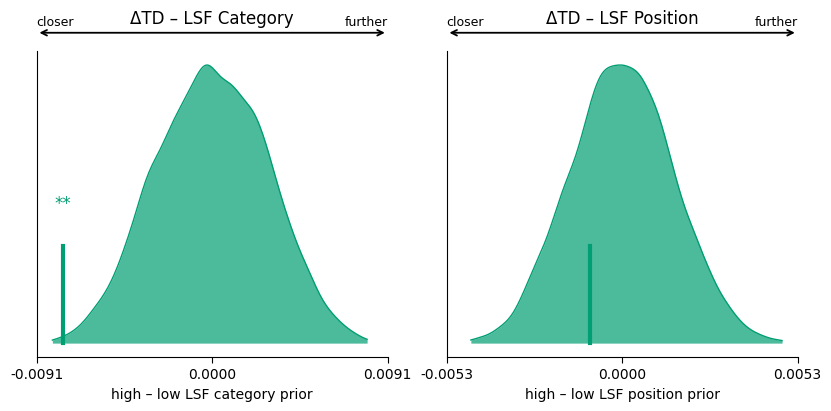

In [ ]:
META_PATH      = 'downloads/hvm_public_extended_meta.csv'
EVEN_PATH      = 'downloads/Spike_count_even_sessions.npy'
ODD_PATH       = 'downloads/Spike_count_odd_sessions.npy'
CAT_PROB_PATH  = 'mean_predprob_per_trial_lowpass.npy'
POS_ERR_PATH   = 'mean_pos_error_per_trial.npy'

FIG_DIR        = 'Figures'
STAT_DIR       = 'Statistics'
N_PERM         = 10_000   # permutations / sign-flips
RNG_SEED       = 42

PALETTE = {'Perm': '#009E73', 'Obs': '#009E73'}
plt.rcParams.update({"svg.fonttype": "none"})  # editable text in SVG

# Create Statistics directory if it doesn't exist
os.makedirs(STAT_DIR, exist_ok=True)

# Needed here (in case not imported above in the notebook)
import seaborn as sns
from statsmodels.stats.multitest import multipletests

# ───────────────────────────── helper functions ──────────────────────────────
@jit
def sqeucl(mat: jnp.ndarray, vec: jnp.ndarray) -> jnp.ndarray:
    """Row-wise mean-squared Euclidean distance to *vec*."""
    return jnp.mean((mat - vec) ** 2, axis=1)

def q_to_stars(q: float) -> str:
    if q < 1e-4: return '****'
    if q < 1e-3: return '***'
    if q < 1e-2: return '**'
    if q < 5e-2: return '*'
    return ''

def _set_three_ticks(ax):
    """Set symmetric x-limits and ticks at [-L, 0, +L] with 0 centered."""
    xmin, xmax = ax.get_xlim()
    L = float(max(abs(xmin), abs(xmax)))
    if not np.isfinite(L) or L == 0:
        L = 1.0
    ax.set_xlim(-L, L)
    ax.set_xticks([-L, 0.0, L])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

def plot_rotated_density_single(ax, title, obs, null_dist, p_or_q_val, xlabel):
    """One rotated-density panel (with three xticks)."""
    # KDE grid on 0.1–99.9 % range
    p_lo, p_hi = np.percentile(null_dist, [0.1, 99.9])
    pad = 0.02 * (p_hi - p_lo)
    x_g = np.linspace(p_lo - pad, p_hi + pad, 200)
    dens = gaussian_kde(null_dist)(x_g)
    dens[dens < 0.005 * dens.max()] = 0
    max_d = dens.max() or 1e-8

    # density + observed line
    ax.fill_between(x_g, 0, dens, color=PALETTE['Perm'], alpha=.7, lw=0)
    ax.plot(x_g, dens, color=PALETTE['Perm'], lw=1)
    ln = 0.35 * max_d
    ax.plot([obs, obs], [0, ln], color=PALETTE['Obs'], lw=3)

    # stars (interpret input as q-value)
    if (stars := q_to_stars(p_or_q_val)):
        ax.text(obs, ln + 0.12 * max_d, stars, ha='center', va='bottom',
                fontsize=12, color=PALETTE['Obs'])

    # cosmetics
    ax.set_yticks([])
    ax.tick_params(axis='y', left=False, labelleft=False)
    for s in ax.spines.values():
        s.set_visible(False)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.tick_params(axis='x', bottom=True, labelbottom=True, length=4)
    ax.set_title(title, fontsize=12, pad=20)

    # enforce three ticks after limits settle
    _set_three_ticks(ax)

    # arrow
    arrow_y = 1.06
    ax.annotate('', xy=(1, arrow_y), xytext=(0, arrow_y),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle='<->', lw=1.3, color='black'),
                clip_on=False)
    ax.text(0, arrow_y + 0.015, 'closer', transform=ax.transAxes,
            ha='left', va='bottom', fontsize=9)
    ax.text(1, arrow_y + 0.015, 'further', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=9)

# --- metadata
print('Loading metadata …')
meta = pd.read_csv(META_PATH)
low_var = meta.variation == 0
high_var = meta.variation == 3
high_idx = np.nonzero(high_var.values)[0]
g2h = -np.ones(len(meta), int); g2h[high_idx] = np.arange(high_idx.size)

# --- neural data (100–200 ms)
print('Loading neural data …')
rate = (np.load(EVEN_PATH) + np.load(ODD_PATH)) / 2.0
t_bins = np.arange(0, 200, 10)
late_mask = (t_bins >= 100) & (t_bins <= 200)
X = rate[:, :, late_mask].reshape(rate.shape[0], -1).astype('float32')
X = jnp.array(X)

# --- PCA (50 components)
print('Running PCA (50 comps) …')
Xc = X - X.mean(axis=0)
_, _, Vt = jnp.linalg.svd(Xc, full_matrices=False)
comps = Vt[:50]  # 50 principal axes

# project data
proj_all  = (X - X.mean(axis=0)) @ comps.T
proj_high = proj_all[high_idx]

hv_obj = meta.object_name.values[high_idx]
hv_cat = meta.category_name.values[high_idx]

cat_prob = np.load(CAT_PROB_PATH)
pos_err  = np.load(POS_ERR_PATH)

rng = np.random.default_rng(RNG_SEED)

# Collect per-object ΔTD components (no first subplot)
gain_cat, gain_pos = [], []

for obj in meta.object_name.unique():
    lv_idx = meta[(meta.object_name == obj) & low_var].index.values
    hv_idx = meta[(meta.object_name == obj) & high_var].index.values
    if lv_idx.size == 0 or hv_idx.size == 0:
        continue

    # prototype from LOW-variation in PCA space
    template = proj_all[lv_idx].mean(axis=0)

    # distances for this object’s HIGH-variation images (in PCA space)
    hv_hi = g2h[hv_idx]
    dists = np.asarray(sqeucl(proj_high[hv_hi], template))  # per-image TDs

    # LSF gains (category prior and position prior)
    cp = cat_prob[hv_hi]
    pe = pos_err[hv_hi]

    mask_exp = cp > np.median(cp);  mask_un  = ~mask_exp
    mask_loc = pe < np.median(pe);  mask_mis = ~mask_loc

    if mask_exp.any() and mask_un.any():
        gain_cat.append(dists[mask_exp].mean() - dists[mask_un].mean())
    if mask_loc.any() and mask_mis.any():
        gain_pos.append(dists[mask_loc].mean() - dists[mask_mis].mean())

# --- stats (sign-flip nulls for the two ΔTD panels)
emp_cat = float(np.mean(gain_cat)) if len(gain_cat) else np.nan
emp_pos = float(np.mean(gain_pos)) if len(gain_pos) else np.nan

signs_cat = rng.choice([-1, 1], size=(N_PERM, len(gain_cat))) if len(gain_cat) else np.empty((0,0))
signs_pos = rng.choice([-1, 1], size=(N_PERM, len(gain_pos))) if len(gain_pos) else np.empty((0,0))

null_cat = (np.array(gain_cat)[None, :] * signs_cat).mean(axis=1) if len(gain_cat) else np.array([np.nan])
null_pos = (np.array(gain_pos)[None, :] * signs_pos).mean(axis=1) if len(gain_pos) else np.array([np.nan])

# one-sided p-values
p_cat = float((null_cat <= emp_cat).mean()) if len(gain_cat) else np.nan
p_pos = float((null_pos <= emp_pos).mean()) if len(gain_pos) else np.nan

# --- FDR (BH) BEFORE plotting; use q-values on the figures
p_vec = np.array([p_cat, p_pos], dtype=float)
mask = ~np.isnan(p_vec)
q_vec = np.full_like(p_vec, np.nan, dtype=float)
if mask.any():
    _, q_corr, _, _ = multipletests(p_vec[mask], method='fdr_bh')
    q_vec[mask] = q_corr
q_cat, q_pos = q_vec.tolist()

# Save both raw p and FDR-corrected q values
np.save(os.path.join(STAT_DIR, 'p_value_gain_cat.npy'), p_cat)
np.save(os.path.join(STAT_DIR, 'p_value_gain_pos.npy'), p_pos)
np.savez(os.path.join(STAT_DIR, 'q_values_gain.npz'), q_cat=q_cat, q_pos=q_pos)

# --- plotting (ONLY the two ΔTD panels; pass q-values to star-logic)
fig, axes = plt.subplots(1, 2, figsize=(8.2, 4), constrained_layout=True)

plot_rotated_density_single(
    axes[0], 'ΔTD – LSF Category',
    emp_cat, null_cat, q_cat,
    'high – low LSF category prior'
)
plot_rotated_density_single(
    axes[1], 'ΔTD – LSF Position',
    emp_pos, null_pos, q_pos,
    'high – low LSF position prior'
)

sns.despine()
os.makedirs(FIG_DIR, exist_ok=True)
for ext in ('png', 'svg', 'pdf'):
    fig.savefig(os.path.join(FIG_DIR, f'gain_rotated_density.{ext}'), dpi=300)
print(f'Figure saved to {FIG_DIR}/gain_rotated_density.(png|svg|pdf)')
print(f"Saved q-values to {STAT_DIR}/q_values_gain.npz")

## Illustrations of hypothesis

### Example LSF predictors

Saved figure: Figures/extreme_gallery.png


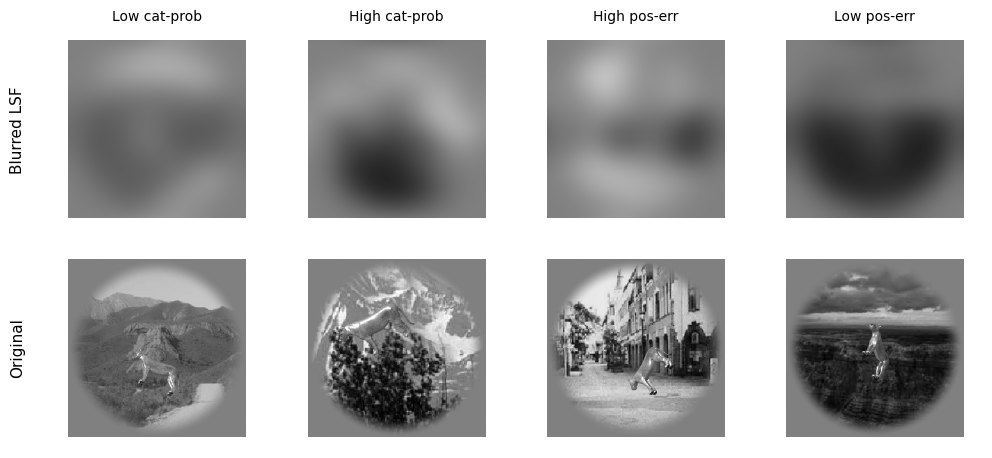

In [ ]:
OBJECT        = "lioness"          # any object in the metadata
VARIATION     = 3              # use high‑variation exemplars
FOV_DEG       = 8.0            # field‑of‑view for Gaussian filter
ZOOM          = 0.5           # image zoom in subplot
OUT_FIG       = "Figures/extreme_gallery.png"
# paths (adjust if needed)
META_CSV      = "downloads/hvm_public_extended_meta.csv"
ZIP_LOW       = "downloads/background_variations_images.zip"
ZIP_HIGH      = "downloads/high_variation_stimuli.zip"
PRED_CAT_NPY  = "mean_predprob_per_trial_lowpass.npy"
PRED_POS_NPY  = "mean_pos_error_per_trial.npy"
# ═══════════════════════════════════════════════════════════

import io, zipfile, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image


# ---------- 2  Load metadata & predictors --------------------------
meta       = pd.read_csv(META_CSV)
cat_pred   = np.load(PRED_CAT_NPY)   # higher = more expected
pos_err    = np.load(PRED_POS_NPY)   # lower  = better localisation

# ---------- 3  Restrict to chosen object & variation ---------------
meta_high  = meta[meta.variation == VARIATION].reset_index(drop=True)
sel        = meta_high[meta_high.object_name == OBJECT]
if len(sel) < 10:
    sys.exit("Not enough images for that selection.")

idx = sel.index.to_numpy()

# ---------- 4  Pick extremes ---------------------------------------
idx_of_extreme = lambda arr, k, largest=True: arr.argsort()[-k:] if largest else arr.argsort()[:k]

lo_cat_idx = idx_of_extreme(cat_pred[idx], 1, largest=False)[0]
hi_cat_idx = idx_of_extreme(cat_pred[idx], 1, largest=True )[0]
hi_pos_idx = idx_of_extreme(pos_err [idx], 1, largest=True )[0]
lo_pos_idx = idx_of_extreme(pos_err [idx], 1, largest=False)[0]

selected_global = idx[[lo_cat_idx, hi_cat_idx, hi_pos_idx, lo_pos_idx]]
labels = ["Low cat‑prob", "High cat‑prob",
          "High pos‑err", "Low pos‑err"]

# ---------- 5  Helper – load PNG from zips -------------------------
zip_low  = zipfile.ZipFile(ZIP_LOW)
zip_high = zipfile.ZipFile(ZIP_HIGH)

def load_sha1(sha: str):
    """Locate image with the given SHA‑1 name in either ZIP archive."""
    for z in (zip_low, zip_high):
        for n in z.namelist():
            if n.endswith(sha):
                return Image.open(io.BytesIO(z.read(n))).convert("L")
    return None

sha_names = meta_high.loc[selected_global, "filename"].tolist()
images    = [load_sha1(s) for s in sha_names]

# ---------- 6  Apply magnocellular low‑pass ------------------------
blurred = []
for im in images:
    if im is None:
        blurred.append(None); continue
    lp = m_pathway_filter_gaussian(np.asarray(im), fov_deg=FOV_DEG)
    if lp.dtype != np.uint8:
        lp = np.clip(lp, 0, 255).astype("uint8")  # absolute range, no rescale
    blurred.append(lp)

# ---------- 7  Plot -------------------------------------------------
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
abs_norm = mcolors.Normalize(vmin=0, vmax=255)  # fixed grey mapping

for col, (orig, blur, lab) in enumerate(zip(images, blurred, labels)):
    for row in (0, 1):
        ax = axes[row, col]
        ax.axis("off")
        arr = blur if row == 0 else orig
        if arr is None:
            ax.text(0.5, 0.5, "MISSING", ha="center", va="center", fontsize=8)
            continue
        if isinstance(arr, Image.Image):
            arr = np.asarray(arr)
        box = OffsetImage(arr, zoom=ZOOM, cmap="gray", norm=abs_norm)
        ab  = AnnotationBbox(box, (0.5, 0.5), frameon=False, pad=0)
        ax.add_artist(ab)
    axes[0, col].set_title(lab, fontsize=10)

axes[0, 0].text(-0.15, 0.5, "Blurred LSF", rotation=90,
                ha="center", va="center", fontsize=11, transform=axes[0, 0].transAxes)
axes[1, 0].text(-0.15, 0.5, "Original",    rotation=90,
                ha="center", va="center", fontsize=11, transform=axes[1, 0].transAxes)


fig.tight_layout(rect=[0, 0, 1, 0.94])
fig.savefig(OUT_FIG, dpi=600)
print("Saved figure:", OUT_FIG)


# Download figures and statistics

In [ ]:
import os
from google.colab import files

# Define the directories to zip
directories_to_zip = ["Figures", "Statistics"]
zip_filename = "results_LSF_top_down.zip"

# Check if directories exist before zipping
existing_directories = [d for d in directories_to_zip if os.path.exists(d)]

if existing_directories:
    # Create a zip archive of the specified directories
    zip_command = f"zip -r {zip_filename} {' '.join(existing_directories)}"
    os.system(zip_command)

    # Provide a download link for the zip file
    if os.path.exists(zip_filename):
        print(f"Created {zip_filename}. You can download it using the link below.")
        files.download(zip_filename)
    else:
        print(f"Failed to create {zip_filename}.")
else:
    print("Neither the 'Figures' nor the 'Statistics' directory was found.")

Created results_LSF_top_down.zip. You can download it using the link below.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>